### Импортируем библиотеки

In [1]:
# Импорт библиотек для проведения расчетов
import pandas as pd
import numpy as np

In [2]:
# Импорт библиотек для построения и визуализации графов
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
# Библиотека для построения ассоциативных правил: mlxtend
# Документация библиотеки: http://rasbt.github.io/mlxtend/

# Для установки библиотеки требуется раскомментировать строку 5
# ! python3.7 -m pip install --upgrade mlxtend

In [4]:
# Импорт пакетов для выполнения ассоциативных правил
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import fpmax

### Загрузка данных

In [5]:
# Указываем путь к файлу
# При работе с google colab существует 2 варианта загрузки файла:
# 1. Через google drive
# 2. Через левое меню: "файлы" -> "загрузить в сессионное хранилище" -> "скопировать файл" (при наведении на файл)
file_path = 'assoc.sas7bdat'

In [6]:
# Загружаем данные из SAS файла
df = pd.read_sas(file_path, encoding='latin-1')
# Пример данных
df.head()

,CUSTOMER,TIME,PRODUCT
0,0.0,0.0,hering
1,0.0,1.0,corned_b
2,0.0,2.0,olives
3,0.0,3.0,ham
4,0.0,4.0,turkey


### Часть 1: Построение моделей ассоциативных правил

In [7]:
# Создадим список транзакций в формате [[1,4,5], [3,5,3], ....]
# Каждый элемент списка - список того, что купил клиент
transactions = df.groupby('CUSTOMER').aggregate({"PRODUCT":list}).values[:, 0]

In [8]:
# Список покупок для первого клиента
transactions[0]

['hering', 'corned_b', 'olives', 'ham', 'turkey', 'bourbon', 'ice_crea']

In [9]:
# Построим модель apriori или fpgrowth (указывается в качестве параметра mode)
def get_frequent_items(transac, model = "apriori"):
    te = TransactionEncoder()
    te_ary = te.fit(transac).transform(transac)
    df = pd.DataFrame(te_ary, columns=te.columns_)
    if model == "apriori":
        return apriori(df, min_support=0.1, use_colnames=True)
    elif model == "fpgrowth":
        return fpgrowth(df, min_support=0.1, use_colnames=True)
    return None

frequent_itemsets = get_frequent_items(transactions, model = "apriori")

In [10]:
frequent_itemsets.head()

,support,itemsets
0,0.313686,(apples)
1,0.304695,(artichok)
2,0.362637,(avocado)
3,0.391608,(baguette)
4,0.402597,(bourbon)


In [11]:
# Cгенерируем ассоциативные правила с поддержкой выше 0.2 и выведем первые 5
association_rules(frequent_itemsets, metric="support", min_threshold=0.2).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(artichok),(avocado),0.304695,0.362637,0.210789,0.691803,1.907700,0.100295,2.068038
1,(avocado),(artichok),0.362637,0.304695,0.210789,0.581267,1.907700,0.100295,1.660497
2,(heineken),(artichok),0.599401,0.304695,0.251748,0.420000,1.378426,0.069114,1.198801
3,(artichok),(heineken),0.304695,0.599401,0.251748,0.826230,1.378426,0.069114,2.305336
4,(baguette),(avocado),0.391608,0.362637,0.214785,0.548469,1.512446,0.072773,1.411560


**Постройте модели (apriori и fpgrowth) с minimum confidence 30%.**

**Ответьте на вопросы:**
1.   Сколько различных значений принимает переменная PRODUCT?
2.   Найдите самое достоверное правило (если их несколько, то правило с самой большой поддержкой), содержащее продукт cracker (вариант I) или chicken (вариант II) в самом начале цепочки. Что это за правило? Что оно обозначает (дайте словесную интерпретацию)
3.   Какая у него поддержка? Что означает это число?

### Q1.1

In [12]:
len(df["PRODUCT"].unique())

20

### Q1.2

In [13]:
ar = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)
ar.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(apples),(avocado),0.313686,0.362637,0.138861,0.442675,1.220710,0.025107,1.143611
1,(avocado),(apples),0.362637,0.313686,0.138861,0.382920,1.220710,0.025107,1.112196
2,(apples),(baguette),0.313686,0.391608,0.146853,0.468153,1.195462,0.024011,1.143922
3,(baguette),(apples),0.391608,0.313686,0.146853,0.375000,1.195462,0.024011,1.098102
4,(corned_b),(apples),0.390609,0.313686,0.150849,0.386189,1.231132,0.028320,1.118119


In [14]:
ar[ar["antecedents"].apply(lambda x: "chicken" in x)].sort_values(by=["confidence", "support"], ascending=False).iloc[0]

antecedents           (sardines, ice_crea, chicken)
consequents                                  (coke)
antecedent support                         0.115884
consequent support                         0.295704
support                                    0.115884
confidence                                      1.0
lift                                       3.381757
leverage                                   0.081617
conviction                                      inf
Name: 753, dtype: object

Если покупатель приобрел мороженое, сардины и курицу, то он, вероятно, купит кока-колу.
(на самом деле есть несколько правил с таким же условием на достоверность и поддержку,
содержащих курицу в левой части правила)

### Q1.3

Правило имеет поддержку 1, значит оно выполняется всегда в рамках данной выборки при выполнении условия в левой
части правила.

### Часть 2: Анализ графов связности

In [15]:
# Построим направленный мультиграф
# Граф построен на направленных связях последовательных покупок
G=nx.MultiDiGraph()
for t in transactions:
    for i in range(len(t) - 1):
        G.add_edge(t[i],t[i+1])

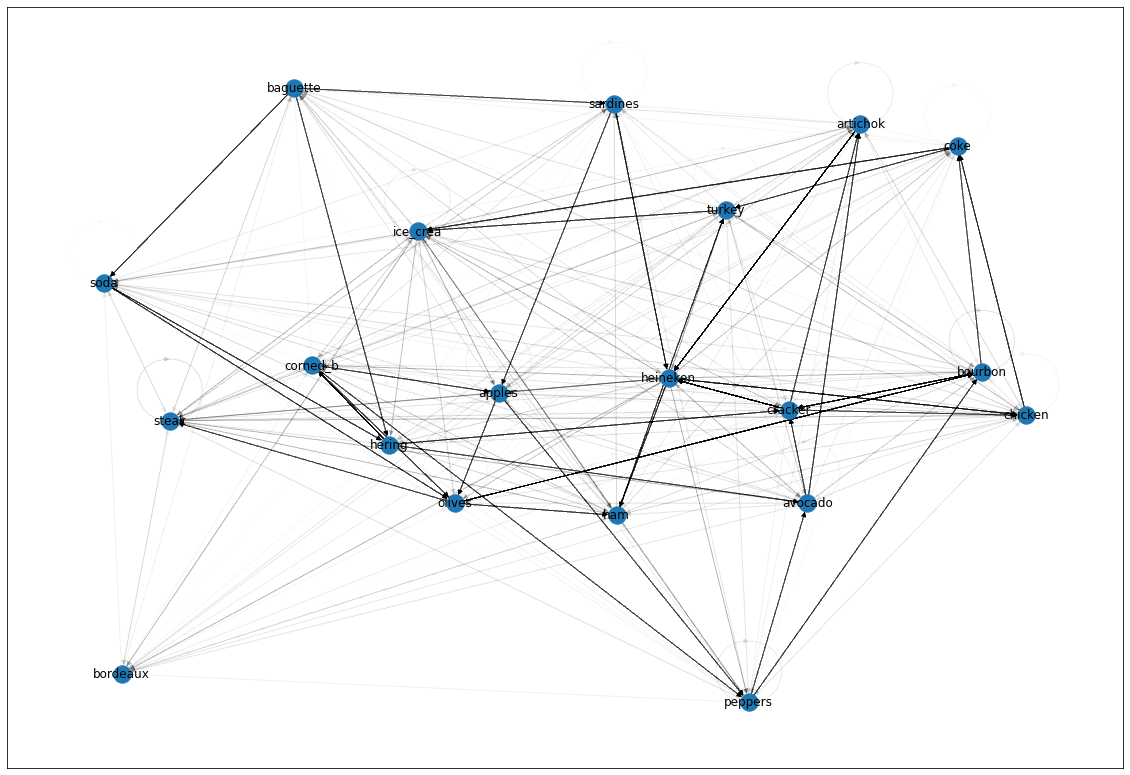

In [16]:
# Визуализируем граф
plt.figure(figsize=(20, 14))
pos = nx.spring_layout(G)
nodes = nx.draw_networkx_nodes(G, pos)
edges = nx.draw_networkx_edges(G, pos, alpha=0.01)
labels = nx.draw_networkx_labels(G, pos)

In [17]:
# Также, можно рассчитать метрики центральности
# Все доступные метрики: https://networkx.org/documentation/stable/reference/algorithms/centrality.html

# Пример расчета меры closeness
nx.closeness_centrality(G)

{'hering': 0.9047619047619048,
 'corned_b': 1.0,
 'olives': 0.95,
 'ham': 1.0,
 'turkey': 0.9047619047619048,
 'bourbon': 1.0,
 'ice_crea': 1.0,
 'baguette': 0.8636363636363636,
 'soda': 1.0,
 'cracker': 0.9047619047619048,
 'heineken': 0.8636363636363636,
 'avocado': 1.0,
 'artichok': 1.0,
 'sardines': 0.95,
 'coke': 1.0,
 'peppers': 0.95,
 'apples': 1.0,
 'steak': 1.0,
 'chicken': 1.0,
 'bordeaux': 0.6129032258064516}

**Вопрос части 2**: посмотрите на график и ответьте на вопрос после какого продукта обычно приобретается soda (вариант I) или sardines (вариант II)

### Q2.1

Багет